## Урок 5. Вебинар “Предел функции”

### Найти предел функции:

1. $$
\lim_{x \to \infty} \frac{(23-2x^2)(3x^2+17)^2}{4x^6+x-1}
$$

In [36]:
# Предел при x, стремящемся к бесконечности, имеет неопределенность вида бесконечность, деленная на бесконечность.
# Так как в числителе и знаменателе полиномы, то отбрасываем все их члены кроме старших членов в самой большой степени.

$$
\lim_{x \to \infty} \frac{(23-2x^2)(3x^2+17)^2}{4x^6+x-1} = \frac{-2x^2 3^2x^4}{4x^6} = \frac{-18x^6}{4x^6} = \frac{-18}{4} = -\frac{9}{2} = -4.5
$$

2. $$
\lim_{x \to \infty} \frac{(97-2x)^3}{2x(3x^2+15)+8x}
$$

In [2]:
# Предел при x, стремящемся к бесконечности, имеет неопределенность вида бесконечность, деленная на бесконечность.
# Так как в числителе и знаменателе полиномы, то отбрасываем все их члены кроме старших членов в самой большой степени.

$$
\lim_{x \to \infty} \frac{(97-2x)^3}{2x(3x^2+15)+8x} = \frac{(-2)^3x^3}{2x3x^2} = \frac{-8x^3}{6x^3} = \frac{-8}{6} = -\frac{4}{3} = -1.(3) 
$$

3. $$
\lim_{x \to \infty} \frac{2x^3+13x(x+18)}{(27-x)(2x+19)^2}
$$

In [3]:
# Предел при x, стремящемся к бесконечности, имеет неопределенность вида бесконечность, деленная на бесконечность.
# Так как в числителе и знаменателе полиномы, то отбрасываем все их члены кроме старших членов в самой большой степени.

$$
\lim_{x \to \infty} \frac{2x^3+13x(x+18)}{(27-x)(2x+19)^2} = \frac{2x^3}{-x2^2x^2} = \frac{2x^3}{-4x^3} = \frac{2}{-4} = -\frac{1}{2} = -0.5
$$

4. $$
\lim_{x \to 6} \frac{x^2-36}{x^2-x-30}
$$

In [41]:
# Предел при x, стремящемся к x0, имеет неопределенность вида ноль, деленный на ноль.
# Так как в числителе и знаменателе полиномы, то раскладываем их на произведение полиномов низшего порядка.

$$
\lim_{x \to 6} \frac{x^2-36}{x^2-x-30} = \frac{(x-6)(x+6)}{(x-6)(x+5)} = \frac{(x+6)}{(x+5)} = \frac{6+6}{6+5} = \frac{12}{11} = 1.(09)
$$

5. $$
\lim_{x \to 7} \frac{x^2-49}{x^2-13x+42}
$$

In [44]:
# Предел при x, стремящемся к x0, имеет неопределенность вида ноль, деленный на ноль.
# Так как в числителе и знаменателе полиномы, то раскладываем их на произведение полиномов низшего порядка.

$$
\lim_{x \to 7} \frac{x^2-49}{x^2-13x+42} = \frac{(x-7)(x+7)}{(x-7)(x-6)} = \frac{(x+7)}{(x-6)} = \frac{7+7}{7-6} = \frac{14}{1} = 14
$$

6. \* $$
\lim_{x \to 7} \frac{\sqrt{x+2}-\sqrt[3]{x+20}}{\sqrt[4]{x+9}-2}
$$

In [53]:
# Предел при x, стремящемся к x0, имеет неопределенность вида ноль, деленный на ноль.
# Так как в числителе и знаменателе разности, то доумножим числитель и знаменатель на суммы.

$$
\lim_{x \to 7} \frac{\sqrt{x+2}-\sqrt[3]{x+20}}{\sqrt[4]{x+9}-2} = \frac{\sqrt{x+2}-\sqrt[3]{x+20}}{\sqrt[4]{x+9}-2} \cdot \frac{\sqrt{x+2}+\sqrt[3]{x+20}}{\sqrt{x+2}+\sqrt[3]{x+20}} \cdot \frac{\sqrt[4]{x+9}+2}{\sqrt[4]{x+9}+2} = \frac{x+2-\sqrt[3]{(x+20)^2}}{\sqrt{x+9}-4} \cdot \frac{\sqrt[4]{x+9}+2}{\sqrt{x+2}+\sqrt[3]{x+20}}
$$

In [49]:
# Дальше не понятно как избавиться от неопределенности вида ноль, деленный на ноль в первой дроби.

7. $$
\lim_{x \to 0} \frac{\sqrt 2 x^2 \sin 4 x}{(1-\cos 2 x)^{\frac{3}{2}}}
$$

C:\Users\Ne0\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


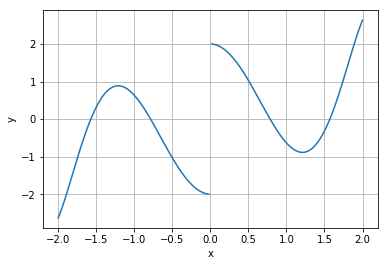

In [73]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
x = np.linspace(-2, 2, 201)
plt.plot(x, 2**(1/2) * x**2 * np.sin(4*x) / (1-np.cos(2*x))**(3/2) )
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

# После построения графика видим, что предел в 0- это -2, в 0+ это 2.
# Таким образом есть только одностороние пределы в точке 0 и нет общего предела в точке 0.

In [ ]:
# Если решать через формулы, то используем первый замечательный предел и следствия из него.

$$
\lim_{x \to 0} \frac{\sqrt 2 x^2 \sin 4 x}{(1-\cos 2 x)^{\frac{3}{2}}} = \frac{\sqrt 2 x^2 \sin 4 x}{(2\sin^2 x)^{\frac{3}{2}}} = \frac{\sqrt 2 x^2 \sin 4 x}{2^{\frac{3}{2}} \sin ^3 x} = \frac{x\sqrt 2 x^2 \sin 4 x}{x\sqrt {2^3} \sin ^3 x} = \frac{x^3 \sin 4 x}{x\sqrt\frac{2^3}{2} \sin ^3 x} = \\
= \frac{x^3 \sin 4 x}{x\sqrt{2^2} \sin ^3 x} = \frac{x^3 \sin 4 x}{2x \sin ^3 x} = \frac{2 x^3 \sin 4 x}{2 \cdot 2x \sin ^3 x} = 2 \cdot \frac{x^3 }{\sin ^3 x} \cdot \frac{\sin 4 x}{4 x} = 2 \cdot 1 \cdot 1 = 2
$$

8. $$
\lim_{x \to 0} \frac{3 x \operatorname{tg} 4 x}{1-\cos 4 x}
$$

In [54]:
# Используем первый замечательный предел и следствия из него.

$$
\lim_{x \to 0} \frac{3 x \operatorname{tg} 4 x}{1-\cos 4 x} = \frac{3 x \operatorname{tg} 4 x}{2\sin^2 2 x} = \frac{4x \cdot 3 x \operatorname{tg} 4 x}{4x \cdot 2\sin^2 2 x} = \frac{3}{2} \cdot \frac{(2x)^2}{\sin^2 2 x} \cdot \frac{\operatorname{tg} 4 x}{4 x} = \frac{3}{2} \cdot 1 \cdot 1 = \frac{3}{2} = 1.5
$$

9. $$
\lim_{x \to \infty}\left(\frac{4 x}{4 x+3}\right)^{\frac{5 x^2}{7 x-1}}
$$

In [66]:
# Используем второй замечательный предел и следствия из него.

$$
\lim_{x \to \infty}\left(\frac{4 x}{4 x+3}\right)^{\frac{5 x^2}{7 x-1}} = \left(\frac{4 x+3 -3}{4 x+3}\right)^{\frac{5 x^2}{7 x-1}} = \left(1 + \frac{-3}{4 x+3}\right)^{\frac{5 x^2}{7 x-1}} = \left(1 + \frac{-3}{4 x+3}\right)^{\frac{4 x+3}{-3} \cdot \frac{-3}{4 x+3} \cdot \frac{5 x^2}{7 x-1}} = \\ = \left(1 + \frac{-3}{4 x+3}\right)^{\frac{4 x+3}{-3} \cdot \frac{-3}{4 x+3} \cdot \frac{5 x^2}{7 x-1}} = e^{\frac{-3}{4 x+3} \cdot \frac{5 x^2}{7 x-1}} = e^{\frac{-3}{4} \cdot \frac{5}{7}} = e^{\frac{-15}{28}} = e^{-0.53(571428)} = 0.58525
$$

10. \* $$
\lim_{x \to+\infty} \frac{\ln (x^2-x+1)}{\ln (x^{10}+x+1)}
$$

In [67]:
# Сложновато

11. $$
\lim_{x \to 0} \frac{5^x-1}{x}
$$

In [68]:
#  Воспользуемся следствием из второго замечательного предела.

$$
\lim_{x \to 0} \frac{5^x-1}{x} = \lim_{x \to 0} \frac{5^x\ln 5}{1} = \ln 5
$$